In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('..')
import pandas as pd
from model import VAE, sample, plus_encode_data, random_swap
import seaborn as sns
import input_pipeline

2024-03-30 07:41:47.382585: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 07:41:47.451635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 07:41:47.451695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 07:41:47.453347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 07:41:47.463106: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 07:41:47.463870: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [7]:
def load_model_at_T(t,  latent_dim = 200):
    model = VAE(latent_dim)
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(f'models/vae{t:.1f}.h5')
    return model

In [8]:
temps = np.arange(2.0, 3.0, 0.1)
titles = [f"Temperature: {t:.2}" for t in temps]
models = {t: load_model_at_T(t) for t in temps}

In [20]:
temp = 2.0
model = load_model_at_T(temp)
batch_size = 5000

trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)

# data mc trainset
data_mc = next(iter(train_set))
data_plus = plus_encode_data(data_mc)
encoded = model.encode(data_plus)

# logvar, mean
means, vars =  encoded
means = means.numpy()
vars = vars.numpy()

In [21]:
means.shape

(5000, 200)

In [22]:
from sklearn.manifold import TSNE

In [23]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=10000, verbose=1, random_state=123)
v = tsne.fit_transform(means) 

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.430s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.300688
[t-SNE] KL divergence after 50 iterations with early exaggeration: 79.616333
[t-SNE] KL divergence after 10000 iterations: 3.297824


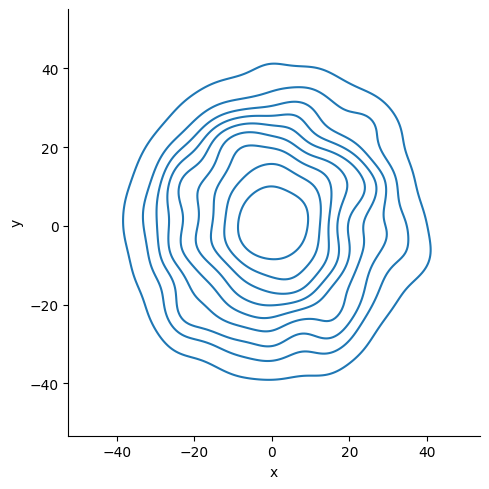

In [24]:
df_tsne = pd.DataFrame()
df_tsne["x"] = v[:,0]
df_tsne["y"] = v[:,1]


sns.displot(df_tsne, x='x', y='y', kind='kde')